In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Other/DeepMask/FaceMaskDataset/CMFD.zip -d /content/CMFD
!unzip /content/drive/MyDrive/Other/DeepMask/FaceMaskDataset/IMFD.zip -d /content/IMFD


#!unzip /content/drive/Shareddrives/deepmask/DeepMask/FaceMaskDataset/IMFD.zip -d /content/IMFD
#!unzip /content/drive/Shareddrives/deepmask/DeepMask/FaceMaskDataset/CMFD.zip -d /content/CMFD

In [ ]:
!mv /content/CMFD/*0/* /content/CMFD
!mv /content/IMFD/*0/* /content/IMFD

In [ ]:
!find /content/CMFD -type d -empty -execdir rmdir {} + 
!find /content/IMFD -type d -empty -execdir rmdir {} + 

In [ ]:
!ls /content/data

CMFD  IMFD


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, MaxPool2d, Linear
import torch.optim as optim
from tqdm import tqdm 

In [ ]:
class Net(nn.Module):
  def __init__(self):
          super().__init__()
          self.pool0 = MaxPool2d(8, 8)
          self.conv1 = Conv2d(3, 6, 5, stride = 2)
          self.pool = MaxPool2d(2, 2)
          self.conv2 = Conv2d(6, 16, 5, stride=2)
          self.conv3 = Conv2d(16, 32, 5, stride = 2)
          #self.fc1 = Linear(288, 128)
          #self.fc2 = Linear(128, 64)
          self.fc3 = Linear(32, 10)
          self.fc4 = Linear(10, 2)

  def forward(self, x):
      x = self.pool0(x)
      print(x.shape)
      x = self.pool(F.relu(self.conv1(x)))
      #print(x.shape)
      x = self.pool(F.relu(self.conv2(x)))
      #print(x.shape)
      x = self.pool(F.relu(self.conv3(x)))
      #print(x.shape)
      x = torch.flatten(x, 1)
      #print(x.shape) # flatten all dimensions except batch
      #x = F.relu(self.fc1(x))
      #print(x.shape)
      #x = F.relu(self.fc2(x))
      #print(x.shape)
      x = F.relu(self.fc3(x))
      x = F.softmax(self.fc4(x))
      return x

In [ ]:
def train(model, train_loader, optimizer, epoch):
    #model.train()
    correct = 0
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0: #Print loss every 100 batch
            print('Train Epoch: {}\tLoss: {:.6f}'.format(
                epoch, loss.item()))
    accuracy = test(model, train_loader)
    return accuracy

In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)

    return accuracy

In [ ]:
def load_data():
  batch_size = 128
  deep_mask_dataset = datasets.ImageFolder(root = '/content/data', transform = transforms.ToTensor())

  train_size = int(0.8*len(deep_mask_dataset))
  test_size = len(deep_mask_dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(deep_mask_dataset, [train_size, test_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True) 
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True) 
  return train_loader, test_loader

In [ ]:
def main():
  num_epochs = 3
  learning_rate = 0.001
  train_loader, test_loader = load_data()
  net = Net()
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)
  train_acc_arr, test_acc_arr = [], []

  for epoch in range(num_epochs):
    train_acc = train(net, train_loader, optimizer, epoch)
    print('\nTrain set Accuracy: {:.0f}%\n'.format(train_acc))
    test_acc = test(net,test_loader)
    print('\nTest set Accuracy: {:.0f}%\n'.format(test_acc))
    train_acc_arr.append(train_acc) 
    test_acc_arr.append(test_acc)
  torch.save(net.state_dict(), "nn.pt")

In [ ]:
if __name__ == '__main__':
    main()


In [ ]:
!pip install mtcnn
!pip install facenet_pytorch

In [ ]:
import cv2
import mtcnn
import matplotlib.pyplot as plt

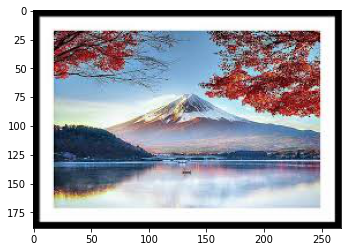

In [ ]:
filename = "nofaceimage.jpg"
pixels = plt.imread(filename)
imgplot = plt.imshow(pixels)
plt.show()

In [ ]:
detector = mtcnn.MTCNN()
faces = detector.detect_faces(pixels)
pred = predict(faces)
print(pred)

0


In [ ]:
def predict(faces):
  if not faces:
    return 0
  else:
    return 1